In [109]:
import copy
import matplotlib.pyplot as plt


import numpy as np



from biggym.envs import SchedulerEnv


from biggym.rewards.matsim import SimpleMATSimTraceScorer


from biggym.rewards.utils import NormalisedScorer

In [122]:
# Hard coded policies


class HomePolicy:
    def __call__(self, obs):
        if obs["curr_state"] == 0:
            return 2  # home -> noop
        if obs["curr_state"] == 1:
            return 0  # work -> home
        if obs["curr_state"] == 2:
            return 2  # travelling -> noop


class WorkPolicy:
    def __init__(self, start, end):
        self.start = start
        self.end = end

    def __call__(self, obs):
        state = obs["curr_state"]
        if state == 2:  # traveling
            return 2  # noop
        time = obs["time"]
        if self.start < time < self.end:
            desired_action = 1
        else:
            desired_action = 0
        if state == desired_action:
            return 2
        return desired_action


class FlipFlopperPolicy:
    def __call__(self, obs):
        state = obs["curr_state"]
        if state == 2:
            return 2
        return 1 - state


class Game:
    def __init__(self, env, discount=1.0):
        self.env = env
        self.discount = discount
        self.accum_reward = 0
        self.rewards = []
        self.accum_rewards = []
        self.states = []

    def run(self, policy):
        obs, info = self.env.reset()
        done = False
        while not done:
            action = policy(obs)
            obs, reward, done, _, info = self.env.step(action)
            self.rewards.append(reward)
            self.accum_reward = (self.accum_reward * self.discount) + reward
            self.accum_rewards.append(self.accum_reward)
            self.states.append(obs["curr_state"])
        return (info["trace"], reward, self.accum_reward)

    def show(self):
        states = [str(s) for s in self.states]
        states = "".join(states)
        print(states)

    def plot(self):
        return plt.plot(self.rewards)

In [128]:
def run_experiment(env, max_duration, steps):
    """Dirty runner for looking at stuff."""

    # stay at home policy
    home_game = Game(env)
    policy = HomePolicy()
    trace, final_score, accum_score = home_game.run(policy)

    print(
        f"Stay at home policy, total: {accum_score}, last_step: {final_score}"
    )
    home_game.show()

    # 9 to 5 policy
    worker_game = Game(env)
    policy = WorkPolicy(9, 17)
    trace, final_score, accum_score = worker_game.run(policy)

    print(f"9 to 5 policy, total: {accum_score}, last_step: {final_score}")
    worker_game.show()

    # flip flopper policy
    flip_game = Game(env)
    policy = FlipFlopperPolicy()
    trace, final_score, accum_score = flip_game.run(policy)
    print(
        f"Flip flopper policy, total: {accum_score}, last_step: {final_score}"
    )
    flip_game.show()

    # brute search space
    final_rewards = np.zeros((steps + 1, steps + 1))
    accum_rewards = np.zeros((steps + 1, steps + 1))
    starts = np.linspace(0.0, max_duration, steps + 1)
    durations = np.linspace(0.0, max_duration, steps + 1)

    best_final_score = -np.inf
    best_accum_score = -np.inf
    best_final_game = None
    best_accum_game = None
    best_final_loc = None
    best_accum_loc = None
    for i, start in enumerate(starts):
        for j, duration in enumerate(durations):
            end = start + duration
            if end > 24:
                final_rewards[i][j] = np.NAN
                accum_rewards[i][j] = np.NAN
                continue

            game = Game(env)
            policy = WorkPolicy(start, end)
            trace, final_score, accum_score = game.run(policy)
            if final_score > best_final_score:
                best_final_score = final_score
                best_final_loc = f"{start}->{end}"
                best_final_game = copy.deepcopy(game)
            if accum_score > best_accum_score:
                best_accum_score = accum_score
                best_accum_loc = f"{start}->{end}"
                best_accum_game = copy.deepcopy(game)

            final_rewards[i][j] = final_score
            accum_rewards[i][j] = accum_score

    print(f"Best final score of {best_final_score}, at {best_final_loc}")
    best_final_game.show()
    print(f"Best accumulated score of {best_accum_score}, at {best_accum_loc}")
    best_accum_game.show()

    # heatmaps for best rewards search

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    img = axs[0].imshow(
        final_rewards,
        cmap="hot",
        interpolation="nearest",
        extent=[0, max_duration, max_duration, 0],
    )
    axs[0].set_xlabel("Duration (hours) of work")
    axs[0].set_ylabel("Start Time (hours) of work")
    plt.colorbar(img, ax=axs[0])
    axs[0].set_title("Final Reward")

    img = axs[1].imshow(
        accum_rewards,
        cmap="hot",
        interpolation="nearest",
        extent=[0, max_duration, max_duration, 0],
    )
    axs[1].set_xlabel("Duration (hours) of work")
    axs[1].set_ylabel("Start Time (hours) of work")
    plt.colorbar(img, ax=axs[1])
    axs[1].set_title("Final Accumulated Reward")

    # plot the rewards for example policies

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    axs[0].plot(home_game.rewards, label="Stay at home")
    axs[0].plot(worker_game.rewards, label="9 to 5")
    axs[0].plot(best_final_game.rewards, label=f"Best ({best_final_loc})")
    axs[0].plot(flip_game.rewards, label="Flip flopper")
    axs[0].set_xticks(
        np.arange(0, steps + 1, 4 * steps / max_duration),
        range(0, max_duration + 1, 4),
    )
    axs[0].legend()
    axs[0].set_title("Reward per step (with flip flop policy)")
    axs[0].set_xlabel("Time in simulation (hours)")
    axs[0].set_ylabel("Reward")

    axs[1].plot(home_game.accum_rewards, label="Stay at home")
    axs[1].plot(worker_game.accum_rewards, label="9 to 5")
    axs[1].plot(best_accum_game.accum_rewards, label=f"Best ({best_accum_loc})")
    axs[1].plot(flip_game.accum_rewards, label="Flip flopper")
    axs[1].set_xticks(
        np.arange(0, steps + 1, 4 * steps / max_duration),
        range(0, max_duration + 1, 4),
    )
    axs[1].legend()
    axs[1].set_title("Accumulated reward (with flip flop policy)")
    axs[1].set_xlabel("Time in simulation (hours)")
    axs[1].set_ylabel("Accumulated Reward")

    # plot the rewards for better example policies

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    axs[0].plot(home_game.rewards, label="Stay at home")
    axs[0].plot(worker_game.rewards, label="9 to 5")
    axs[0].plot(best_final_game.rewards, label=f"Best ({best_final_loc})")
    axs[0].set_xticks(
        np.arange(0, steps + 1, 4 * steps / max_duration),
        range(0, max_duration + 1, 4),
    )
    axs[0].legend()
    axs[0].set_title("Reward per step")
    axs[0].set_xlabel("Time in simulation (hours)")
    axs[0].set_ylabel("Reward")

    axs[1].plot(home_game.accum_rewards, label="Stay at home")
    axs[1].plot(worker_game.accum_rewards, label="9 to 5")
    axs[1].plot(best_accum_game.accum_rewards, label=f"Best ({best_accum_loc})")
    axs[1].set_xticks(
        np.arange(0, steps + 1, 4 * steps / max_duration),
        range(0, max_duration + 1, 4),
    )
    axs[1].legend()
    axs[1].set_title("Accumulated reward")
    axs[1].set_xlabel("Time in simulation (hours)")
    axs[1].set_ylabel("Accumulated Reward")

    return best_final_game, best_accum_game

# Vanilla MATSim Scoring

Normalised between 0 and 1 (hopefully).

The heatmaps show a brute force search of the final step reward and accumulated step reward for durations of the  home -> work -> home plan.

The best final reward is for work from 6:00 to 18:30.

The best accumulated reward is for no work, ie stay at home. This is a problem.

Stay at home policy, total: 40.31759608128251, last_step: 0.9408017984455195
000000000000000000000000000000000000000000000000
9 to 5 policy, total: 39.89760766265105, last_step: 0.9596103220303769
000000000000000000022111111111111122000000000000
Flip flopper policy, total: -26.37894107934683, last_step: -1.5536208080784182
212021202120212202212202212021220221220212021202
Best final score of 0.9785642304937243, at 6.0->18.5
000000000000021111111111111111111111120000000000
Best accumulated score of 40.31759608128251, at 0.0->0.0
000000000000000000000000000000000000000000000000


(<__main__.Game at 0x20950351eb0>, <__main__.Game at 0x20951d58fb0>)

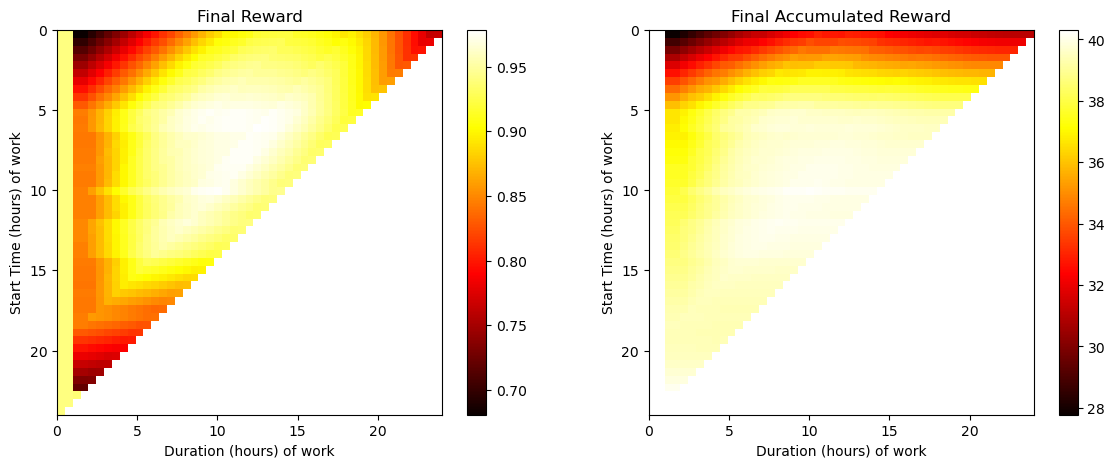

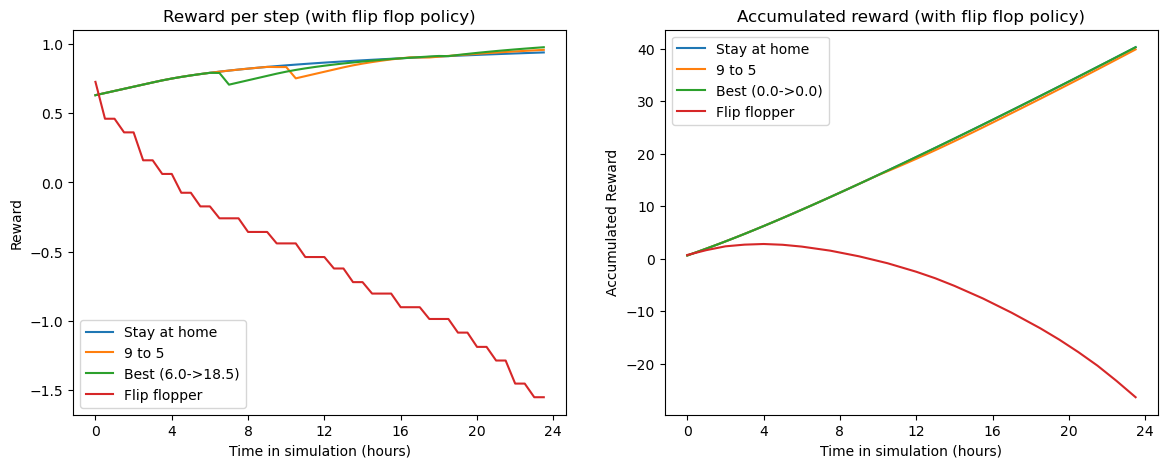

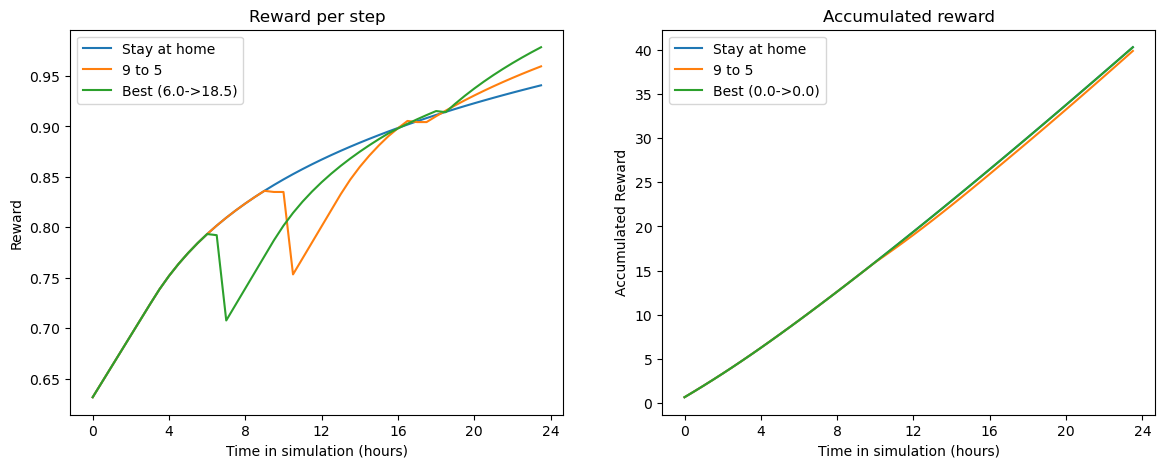

In [129]:
max_duration = 24
steps = 48

# Introduces NormalisedScorer to normalise the scores between 0 and 1 (hopefully)
scorer = NormalisedScorer(SimpleMATSimTraceScorer())
env = SchedulerEnv(
    duration=max_duration, steps=steps, distance=10.0, scorer=scorer
)

run_experiment(env, max_duration, steps)

# Diffing

Diffing works works to create the expected best plan from final accumulated reward (work from 6:00 to 18:00).

However note that step rewards can be negative.

Stay at home policy, total: 0.9408017984455195, last_step: 0.002376071837577376
000000000000000000000000000000000000000000000000
9 to 5 policy, total: 0.9596103220303769, last_step: 0.003700634602061492
000000000000000000022111111111111122000000000000
Flip flopper policy, total: -1.5536208080784182, last_step: -1.1285924361725819e-06
212021202120212202212202212021220221220212021202
Best final score of 0.015339161554567937, at 0.0->20.5
021111111111111111111111111111111111111112000000
Best accumulated score of 0.9785642304937243, at 6.0->18.5
000000000000021111111111111111111111120000000000


(<__main__.Game at 0x2094fc66510>, <__main__.Game at 0x20951db3ad0>)

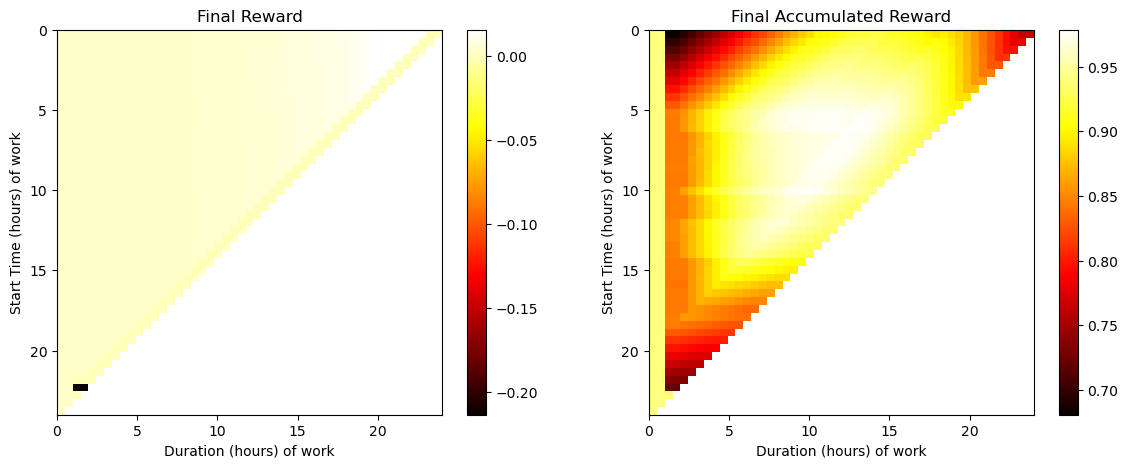

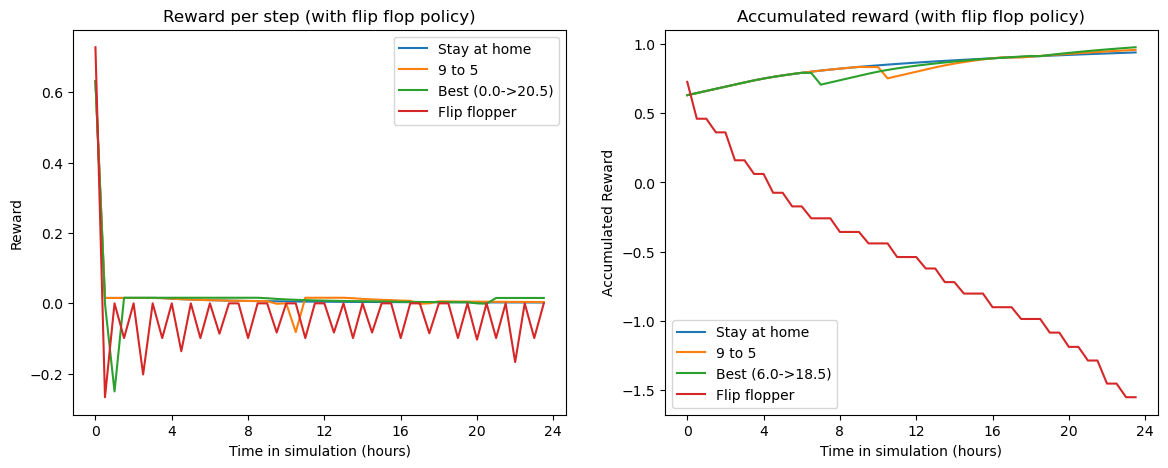

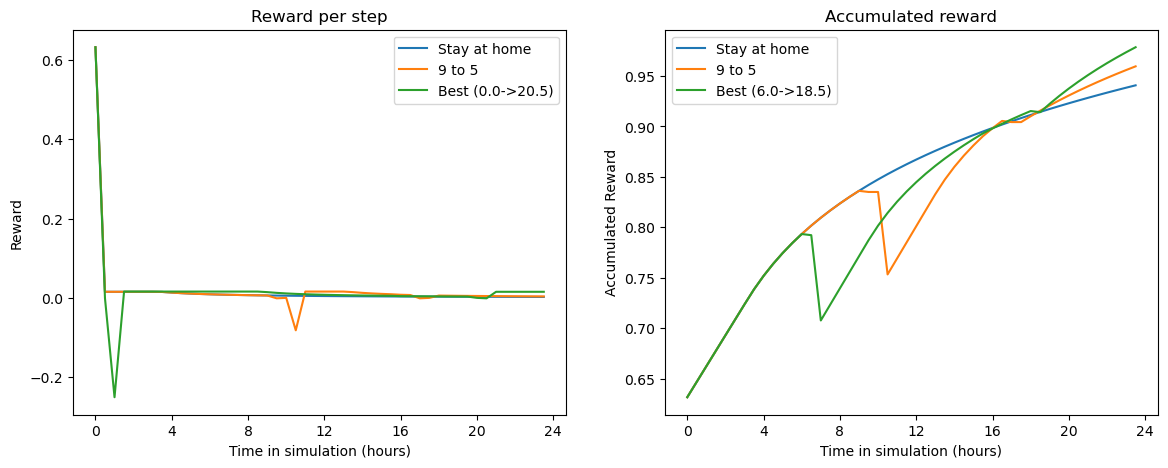

In [132]:
from biggym.rewards.utils import DiffScore

max_duration = 24
steps = 48

scorer = DiffScore(NormalisedScorer(SimpleMATSimTraceScorer()))
env = SchedulerEnv(
    duration=max_duration, steps=steps, distance=10.0, scorer=scorer
)

run_experiment(env, max_duration, steps)

# Consider Plan Expectation

The above rewards are generated from the plan so far at each step.

Here we add a simple rule based expectation for the whole plan (by assuming agent continues current activity until end of day).

This works to bring the rewards and accumulated rewards more in consistency with each other.

Diffing can also be added.

Stay at home policy, total: 45.15848632538495, last_step: 0.9408017984455195
000000000000000000000000000000000000000000000000
9 to 5 policy, total: 45.41485419664308, last_step: 0.9596103220303769
000000000000000000022111111111111122000000000000
Flip flopper policy, total: -20.43049179469792, last_step: -1.5536208080784182
212021202120212202212202212021220221220212021202
Best final score of 0.9785642304937243, at 6.0->18.5
000000000000021111111111111111111111120000000000
Best accumulated score of 45.578107695449674, at 10.0->18.5
000000000000000000000211111111111111120000000000


(<__main__.Game at 0x20951c22d50>, <__main__.Game at 0x20953e6ebd0>)

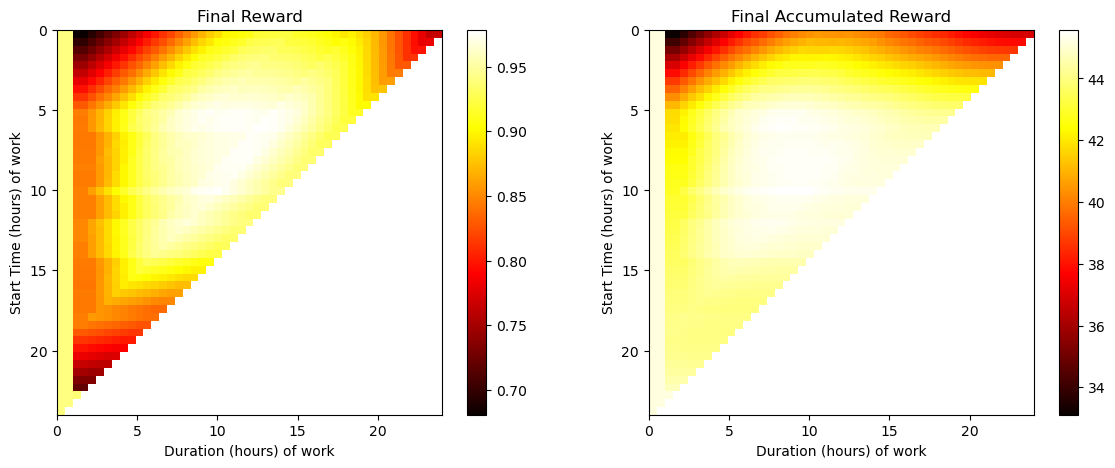

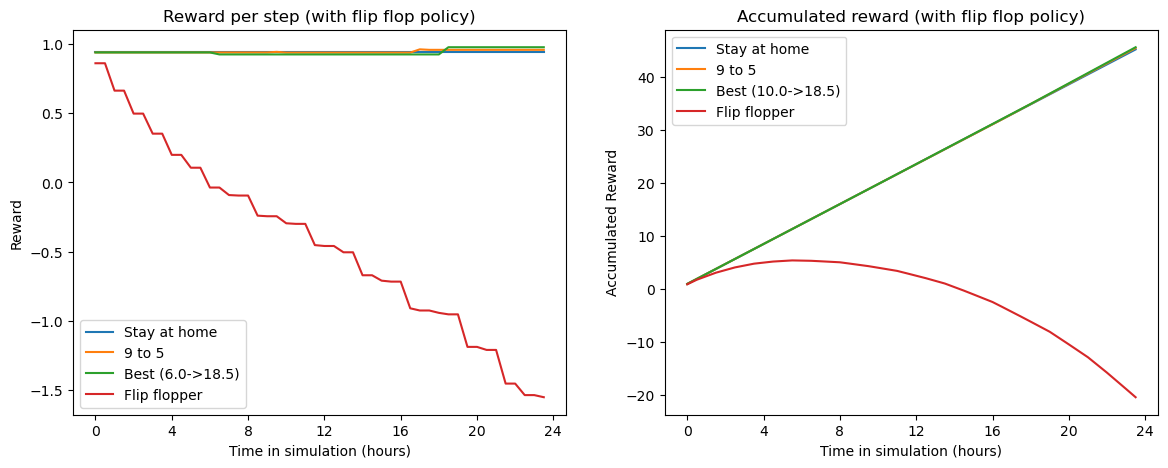

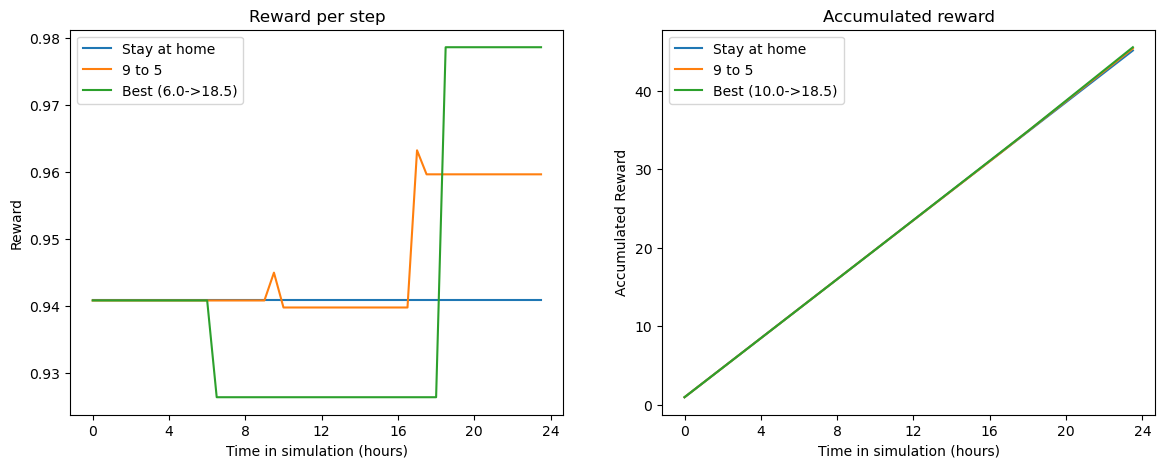

In [133]:
from biggym.rewards.expectation import ContinueDay

max_duration = 24
steps = 48

scorer = NormalisedScorer(
    scorer=SimpleMATSimTraceScorer(), expectation=ContinueDay(24)
)
env = SchedulerEnv(
    duration=max_duration, steps=steps, distance=10.0, scorer=scorer
)

run_experiment(env, max_duration, steps)

# Expectation Plus Diff


Stay at home policy, total: 0.9408017984455195, last_step: 0.0
000000000000000000000000000000000000000000000000
9 to 5 policy, total: 0.9596103220303769, last_step: 0.0
000000000000000000022111111111111122000000000000
Flip flopper policy, total: -1.5536208080784182, last_step: -0.01534029014700411
212021202120212202212202212021220221220212021202
Best final score of 0.0, at 0.0->0.0
000000000000000000000000000000000000000000000000
Best accumulated score of 0.9785642304937243, at 6.0->18.5
000000000000021111111111111111111111120000000000


(<__main__.Game at 0x2094fbfbd40>, <__main__.Game at 0x2094ca77710>)

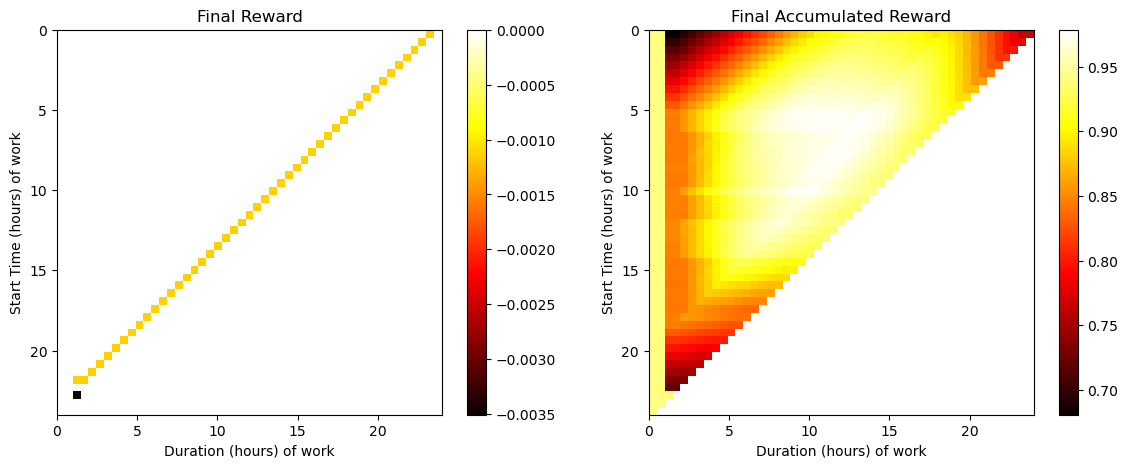

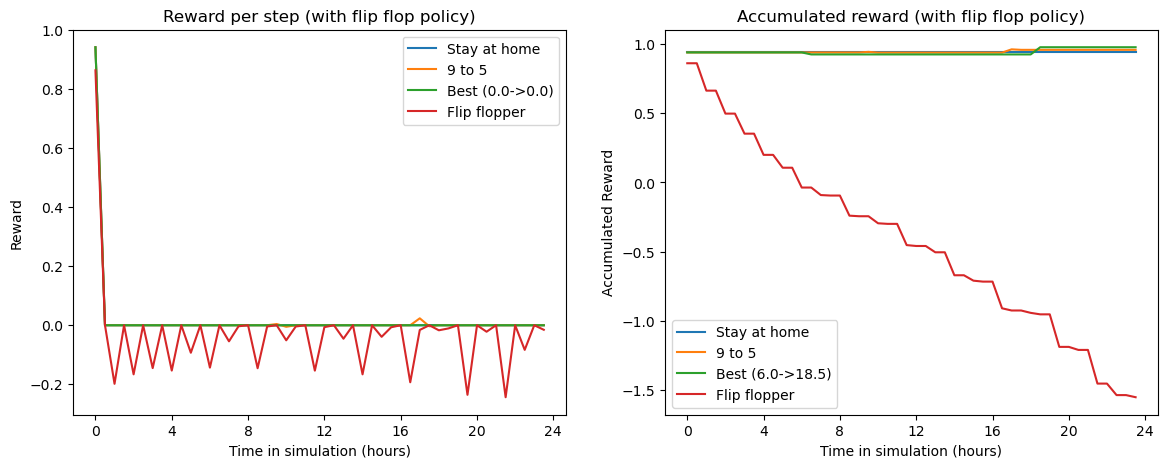

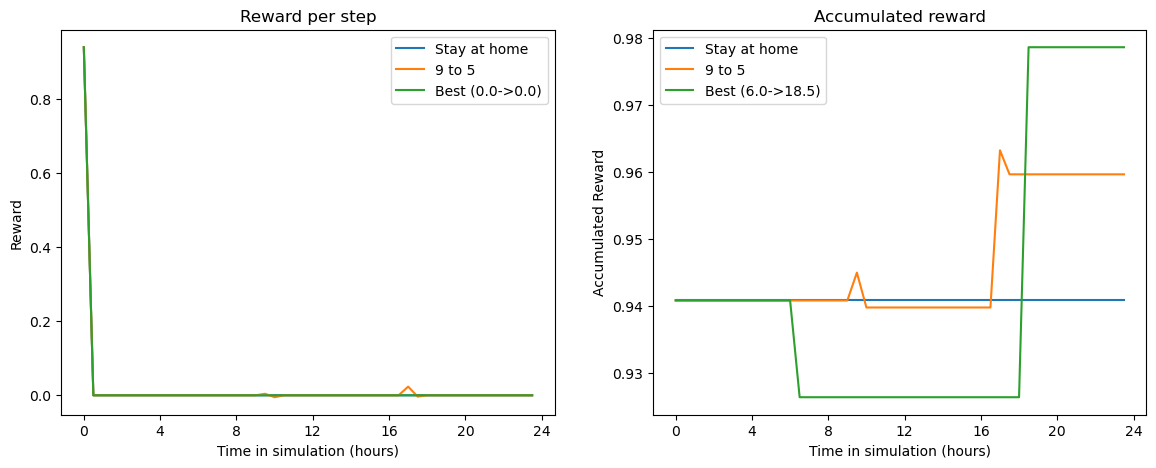

In [134]:
from biggym.rewards.expectation import ContinueDay

max_duration = 24
steps = 48

scorer = DiffScore(
    NormalisedScorer(
        scorer=SimpleMATSimTraceScorer(), expectation=ContinueDay(24)
    )
)
env = SchedulerEnv(
    duration=max_duration, steps=steps, distance=10.0, scorer=scorer
)

run_experiment(env, max_duration, steps)

# Consider Better Plan Expectation

Here we add a better rule based expectation for the whole plan (by assuming agent continues current activity until trying to return home for last 6 hours).

This works to bring the rewards and accumulated rewards more in consistency with each other.

But I think some issue with implementation still...

Diffing can also be added.

Stay at home policy, total: 45.15848632538495, last_step: 0.9408017984455195
000000000000000000000000000000000000000000000000
9 to 5 policy, total: 45.88871240794905, last_step: 0.9938734513625594
000000000000000000022111111111111122000000000000
Flip flopper policy, total: -42.06890258383927, last_step: -3.691277972751435
212021202120212202212202212021220221220212021202
Best final score of 1.0593093224378778, at 3.5->6.5
000000002111120000000000000000000000000000000000
Best accumulated score of 47.59995115144779, at 5.0->6.0
000000000002120000000000000000000000000000000000


(<__main__.Game at 0x2094fcd6e10>, <__main__.Game at 0x2094e72ba70>)

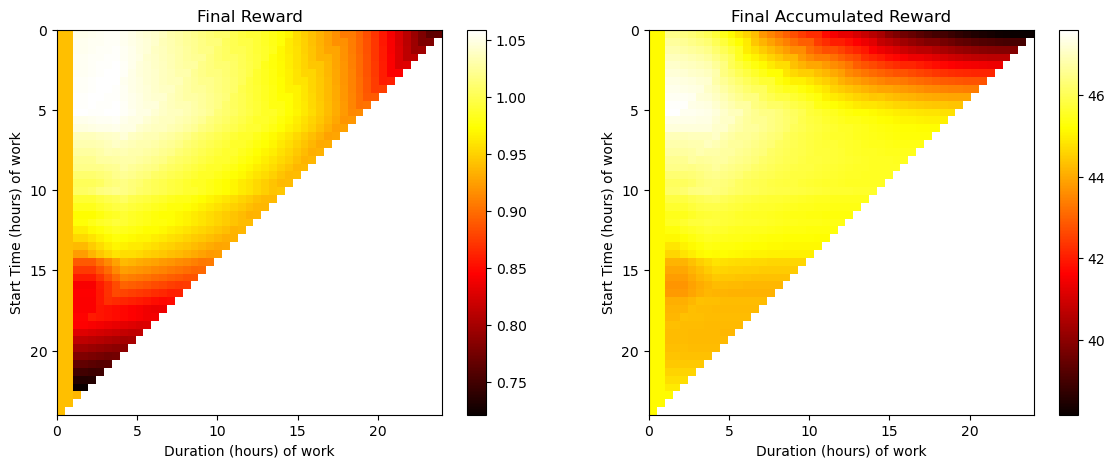

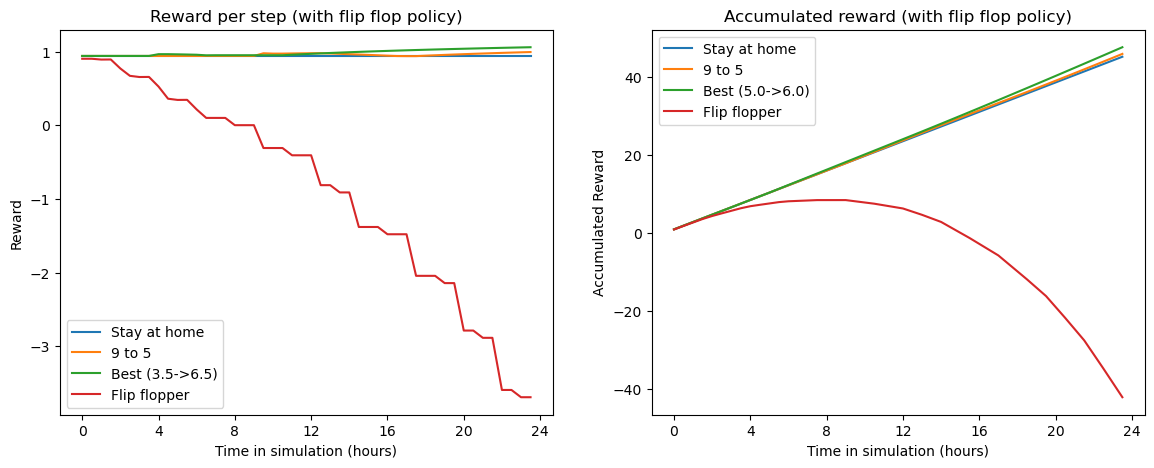

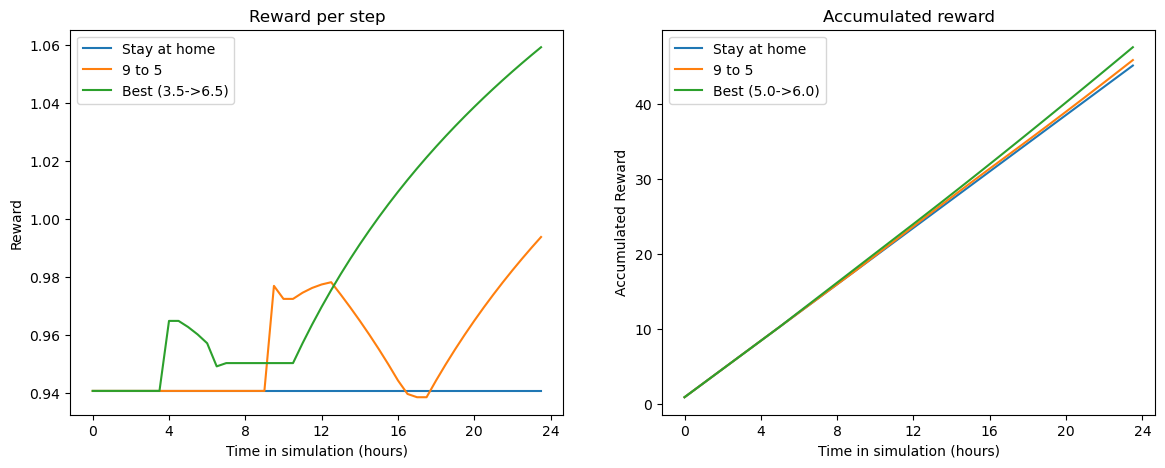

In [135]:
from biggym.rewards.expectation import ReturnDay

max_duration = 24
steps = 48

scorer = NormalisedScorer(
    scorer=SimpleMATSimTraceScorer(),
    expectation=ReturnDay(
        duration=24, return_act=0, target_duration=6, trip_idx=2
    ),
)
env = SchedulerEnv(
    duration=max_duration, steps=steps, distance=10.0, scorer=scorer
)

run_experiment(env, max_duration, steps)